In [38]:
import os
import joblib
import numpy as np
import tensorflow as tf
import gc

from lightgbm import LGBMClassifier, early_stopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout, Normalization
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

### Global Style Helper

In [5]:
# ===============================
# GLOBAL PLOT STYLE (CONSISTENT)
# ===============================
import matplotlib.pyplot as plt
import numpy as np

def set_plot_style():
    plt.rcParams.update({
        "figure.figsize": (8, 6),
        "figure.dpi": 120,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "lines.linewidth": 2
    })


### Confusion Matrix Helper

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    # Hitung confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    
    # Membuat Heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",            # Format angka integer (tanpa koma)
        cmap="Blues",       # GANTI WARNA: Menggunakan tema Biru sesuai gambar
        cbar=True,          # GANTI DESIGN: Menampilkan color bar di samping kanan
        xticklabels=["Benign (0)", "Attack (1)"], # Label bawah (Prediksi)
        yticklabels=["Benign (0)", "Attack (1)"], # Label samping (Aktual)
        annot_kws={"size": 14} # Ukuran font angka di dalam kotak
    )

    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Actual Label", fontsize=12)
    plt.tight_layout()
    plt.show()

### Calibration Plot (Reliability Diagram)

In [29]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


### Loss Analysis

In [27]:
import matplotlib.pyplot as plt

def plot_learning_curve(history, model_name="Model"):
    """
    Plot hanya Loss dan Accuracy (Standar Learning Curve).
    """
    
    # Ambil data dari history
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    
    epochs = range(1, len(loss) + 1)
    
    # Setup Figure (Ukuran disesuaikan untuk 2 grafik)
    plt.figure(figsize=(12, 5))

    # --- 1. LOSS CURVE ---
    plt.subplot(1, 2, 1) # 1 Baris, 2 Kolom, Grafik ke-1
    plt.plot(epochs, loss, label='Train Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{model_name} - Loss Analysis')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- 2. ACCURACY CURVE ---
    if acc:
        plt.subplot(1, 2, 2) # 1 Baris, 2 Kolom, Grafik ke-2
        plt.plot(epochs, acc, label='Train Accuracy')
        if val_acc:
            plt.plot(epochs, val_acc, label='Val Accuracy')
        plt.title(f'{model_name} - Accuracy Analysis')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()




### Start

In [12]:
# ==========================================
# 1. SETUP & CONFIG (WAJIB FLOAT32)
# ==========================================
SEED = 42
tf.keras.backend.clear_session()
# Kebijakan float32 agar kompatibel dengan CPU Snort standar
tf.keras.mixed_precision.set_global_policy('float32') 
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✅ System initialized. Global Policy set to float32.")


✅ System initialized. Global Policy set to float32.


In [39]:
# ==========================================
# 2. LOAD DATASET (ROBUST PATH FINDING)
# ==========================================
print("\n📂 Loading Dataset Binary...")

filename = 'binary.pkl'
# Mencari file secara otomatis (root atau notebooks folder)
cwd = os.getcwd()
possible_paths = [
    os.path.join(cwd, 'processed_data', filename),
    os.path.join(cwd, 'notebooks', 'processed_data', filename),
    'processed_data/' + filename
]

data_pack = None
for path in possible_paths:
    if os.path.exists(path):
        print(f"   File found at: {path}")
        data_pack = joblib.load(path)
        break

if data_pack is None:
    raise FileNotFoundError("❌ File .pkl tidak ditemukan! Pastikan script Prep.ipynb sudah dijalankan.")

# Extract dan Cast ke Float32 (Wajib untuk TensorFlow)
print("   Extracting data...")
X_train = np.array(data_pack['X_train'], dtype=np.float32)
y_train = np.array(data_pack['y_train']).astype(int)

X_val   = np.array(data_pack['X_val'], dtype=np.float32)
y_val   = np.array(data_pack['y_val']).astype(int)

X_test  = np.array(data_pack['X_test'], dtype=np.float32)
y_test  = np.array(data_pack['y_test']).astype(int)

# Hapus dictionary besar untuk hemat RAM
del data_pack
gc.collect()

print(f"✅ Data Loaded. Train Shape: {X_train.shape}")


📂 Loading Dataset Binary...
   File found at: c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\notebooks\processed_data\binary.pkl
   Extracting data...
✅ Data Loaded. Train Shape: (1764525, 43)


In [40]:
# ==========================================
# 3. TEACHER (LIGHTGBM) TRAINING
# ==========================================
print("\n🔄 Training Teacher (LightGBM)...")

lgbm = LGBMClassifier(
    n_estimators=1000, 
    learning_rate=0.05, 
    random_state=SEED, 
    n_jobs=-1,
    class_weight='balanced', # Penting untuk imbalance data
    objective='binary'
)

# Training dengan Early Stopping
callbacks_lgbm = [early_stopping(stopping_rounds=50, verbose=False)]

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=callbacks_lgbm
)

print(f"✅ Teacher Trained! Best Iteration: {lgbm.best_iteration_}")

# Evaluasi Singkat Teacher
acc_teacher = accuracy_score(y_test, lgbm.predict(X_test))
print(f"📊 Teacher Accuracy on Test Set: {acc_teacher*100:.2f}%")


🔄 Training Teacher (LightGBM)...
[LightGBM] [Info] Number of positive: 297986, number of negative: 1466539
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9824
[LightGBM] [Info] Number of data points in the train set: 1764525, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ Teacher Trained! Best Iteration: 747


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📊 Teacher Accuracy on Test Set: 99.91%



📊 --- EVALUASI PERFORMA TEACHER (LightGBM) ---


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Teacher Accuracy : 99.91%
✅ Teacher AUC Score: 1.0000

📝 Classification Report (Teacher):
              precision    recall  f1-score   support

  Normal (0)     0.9999    0.9990    0.9995    314259
  Attack (1)     0.9951    0.9995    0.9973     63854

    accuracy                         0.9991    378113
   macro avg     0.9975    0.9993    0.9984    378113
weighted avg     0.9991    0.9991    0.9991    378113



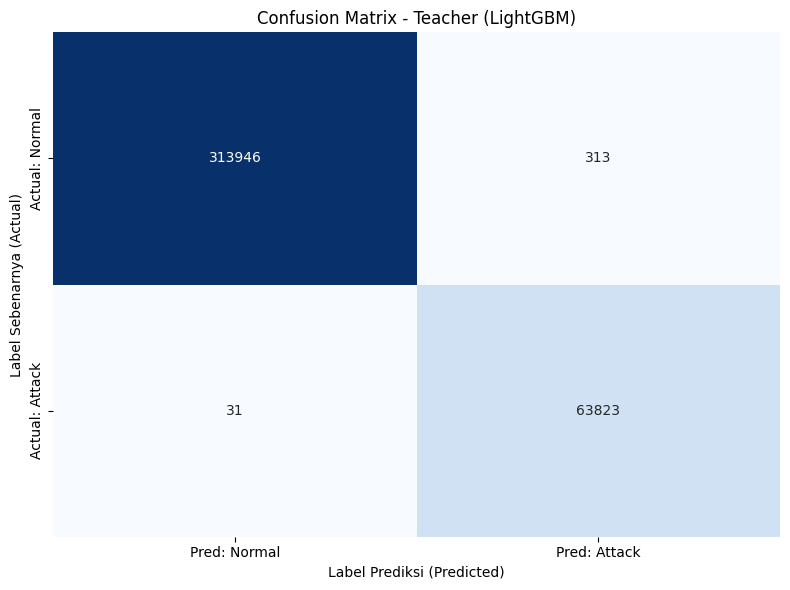

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 --- EVALUASI PERFORMA TEACHER (LightGBM) ---")

# 1. Lakukan Prediksi ke Data Test (Data Murni)
y_pred_lgbm = lgbm.predict(X_test)
# Ambil probabilitas untuk menghitung AUC Score
y_prob_lgbm = lgbm.predict_proba(X_test)[:, 1] 

# 2. Hitung Metrik Utama
acc_teacher = accuracy_score(y_test, y_pred_lgbm)
auc_teacher = roc_auc_score(y_test, y_prob_lgbm)

print(f"✅ Teacher Accuracy : {acc_teacher*100:.2f}%")
print(f"✅ Teacher AUC Score: {auc_teacher:.4f}")

# 3. Tampilkan Laporan Klasifikasi Detail (Precision, Recall, F1-Score)
print("\n📝 Classification Report (Teacher):")
print(classification_report(y_test, y_pred_lgbm, target_names=['Normal (0)', 'Attack (1)'], digits=4))

# 4. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lgbm)

# Plot menggunakan Seaborn Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'])

plt.title('Confusion Matrix - Teacher (LightGBM)')
plt.ylabel('Label Sebenarnya (Actual)')
plt.xlabel('Label Prediksi (Predicted)')
plt.tight_layout()
plt.show()




c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


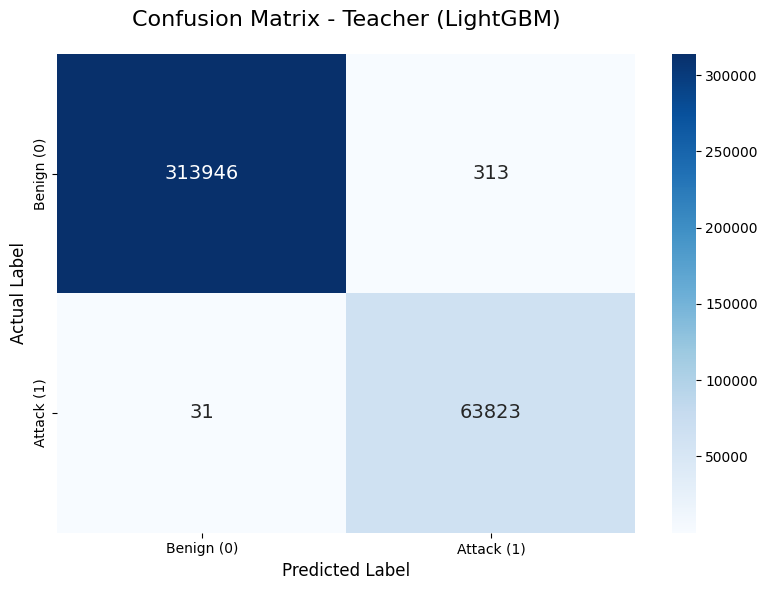

In [42]:
# ===============================
# CONFUSION MATRIX - TEACHER
# ===============================

# Prediksi label
y_pred_lgbm = lgbm.predict(X_test)

# Panggil helper confusion matrix
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred_lgbm,
    title="Confusion Matrix - Teacher (LightGBM)"
)


In [16]:
# ==========================================
# 4. KNOWLEDGE DISTILLATION (SOFT TARGETS)
# ==========================================
print("\n🧪 Generating Soft Targets (Distillation)...")

alpha = 0.9  # 90% percaya Teacher
T = 2.5      # Temperature

# Ambil probabilitas dari Teacher
teacher_probs_train = lgbm.predict_proba(X_train)[:, 1].astype("float32")
teacher_probs_val   = lgbm.predict_proba(X_val)[:, 1].astype("float32")

# Buat Label Distilasi (Campuran Soft + Hard)
y_train_distill = alpha * (teacher_probs_train) + (1 - alpha) * y_train
y_val_distill   = alpha * (teacher_probs_val) + (1 - alpha) * y_val

# Hitung Class Weight untuk Keras
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"⚖️ Class Weights: {class_weight_dict}")

# Bersihkan Teacher
del lgbm, teacher_probs_train, teacher_probs_val
gc.collect()


🧪 Generating Soft Targets (Distillation)...


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


⚖️ Class Weights: {0: np.float64(0.6015949797448278), 1: np.float64(2.9607515118159915)}


2082

In [17]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW

# ==========================================
# 5. BUILD STUDENT MODEL (OPTIMIZED)
# ==========================================
print("\n🏗️ Building Student Model (Slim & Regularized)...")

# A. Normalization Layer
normalizer = Normalization(axis=-1)
normalizer.adapt(X_train) 
print("✅ Normalizer adapted to training data.")

initializer = tf.keras.initializers.HeUniform(seed=SEED)

# B. Arsitektur Model (Dioptimasi: Lebih Ramping + L2 Regularization)
student = Sequential([
    normalizer,
    
    # Layer 1
    # L2 diturunkan (1e-4), Dropout diturunkan (0.25)
    Dense(256, kernel_initializer=initializer, use_bias=False, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25, seed=SEED), 

    # Layer 2
    Dense(128, kernel_initializer=initializer, use_bias=False, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25, seed=SEED),

    # Layer 3
    Dense(64, kernel_initializer=initializer, use_bias=False, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2, seed=SEED), # Layer akhir dropout lebih kecil
    
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

student.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), # Weight decay juga disesuaikan
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)


🏗️ Building Student Model (Slim & Regularized)...
✅ Normalizer adapted to training data.



🚀 Start Training Student...
Epoch 1/40
862/862 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - auc: 0.6344 - loss: 0.1815 - val_auc: 0.6446 - val_loss: 0.1206 - learning_rate: 0.0010
Epoch 2/40
862/862 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - auc: 0.6355 - loss: 0.1112 - val_auc: 0.6347 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 3/40
862/862 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - auc: 0.6228 - loss: 0.0911 - val_auc: 0.6188 - val_loss: 0.0825 - learning_rate: 0.0010
Epoch 4/40
862/862 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - auc: 0.6121 - loss: 0.0820 - val_auc: 0.6036 - val_loss: 0.0779 - learning_rate: 0.0010
Epoch 5/40
862/862 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - auc: 0.6115 - loss: 0.0767 - val_auc: 0.6355 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 6/40
862/862 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - auc: 0.6134 - loss: 0.0736 - val_auc: 0.6382 - val_loss: 0.0689 - learning_rate: 0.0010
Epoch 7/40
862/862 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - auc: 0.6120 - loss: 0.0713 - val_auc: 0.6320 - val_

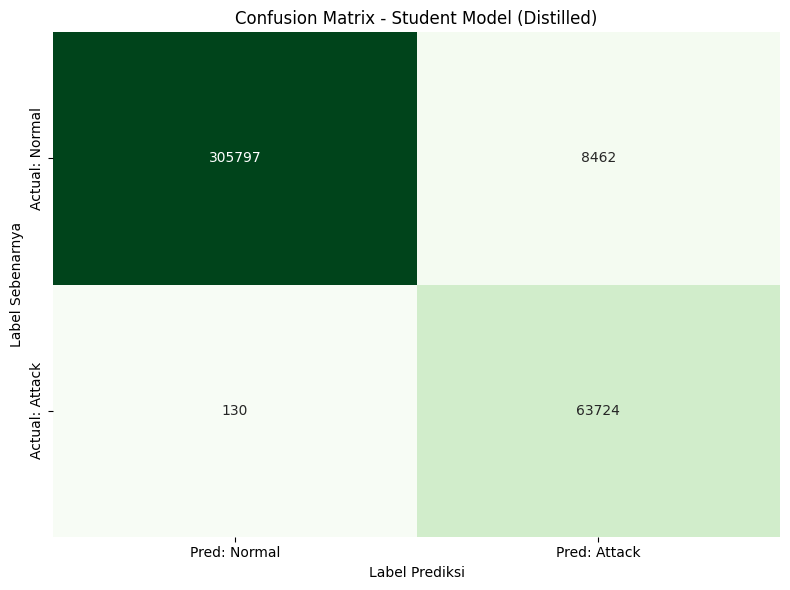

In [18]:
# ==========================================
# 6. TRAINING STUDENT
# ==========================================
print("\n🚀 Start Training Student...")

callbacks_keras = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]

history = student.fit(
    X_train, y_train_distill,       # Label Distilasi (Soft Targets)
    validation_data=(X_val, y_val_distill),
    epochs=40,
    batch_size=2048,
    verbose=1,
    callbacks=callbacks_keras,
    class_weight=class_weight_dict
)

print("\n📊 --- EVALUASI FINAL (Student Model) ---")

# 1. Prediksi ke Data Test (Data Murni)
y_pred_prob = student.predict(X_test, batch_size=2048)
# Konversi probabilitas ke kelas biner (Threshold 0.5)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# 2. Hitung Metrik Utama
acc_student = accuracy_score(y_test, y_pred_class)
auc_student = roc_auc_score(y_test, y_pred_prob)

print(f"✅ Final Accuracy (Student) : {acc_student*100:.2f}%")
print(f"✅ Final AUC Score          : {auc_student:.4f}")

# 3. Classification Report
print("\n📝 Classification Report (Student):")
print(classification_report(y_test, y_pred_class, target_names=['Normal (0)', 'Attack (1)']))

# 4. Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
cm_student = confusion_matrix(y_test, y_pred_class)

sns.heatmap(cm_student, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'])

plt.title('Confusion Matrix - Student Model (Distilled)')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.tight_layout()
plt.show()



In [43]:
print("\n📝 Classification Report (Student):")
print(classification_report(y_test, y_pred_class, target_names=['Normal (0)', 'Attack (1)'], digits=4))


📝 Classification Report (Student):
              precision    recall  f1-score   support

  Normal (0)     0.9996    0.9731    0.9861    314259
  Attack (1)     0.8828    0.9980    0.9368     63854

    accuracy                         0.9773    378113
   macro avg     0.9412    0.9855    0.9615    378113
weighted avg     0.9799    0.9773    0.9778    378113



In [19]:
from pathlib import Path

BASE_DIR = Path("notebooks/models")
BASE_DIR.mkdir(parents=True, exist_ok=True)

print("📁 Model path:", BASE_DIR.resolve())


📁 Model path: C:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\notebooks\notebooks\models


In [20]:
student_path = BASE_DIR / "nFn.keras"
student.save(student_path)

print("✅ Student saved in Keras format")


✅ Student saved in Keras format


In [21]:
import tensorflow as tf

student = tf.keras.models.load_model(
    "notebooks/models/nFn.keras",
    compile=False
)

print("✅ Student model loaded (no retraining)")


✅ Student model loaded (no retraining)


In [22]:
# Prediksi probabilitas (0–1)
y_pred_prob = student.predict(X_test, batch_size=2048).ravel()

print("Pred shape:", y_pred_prob.shape)


185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Pred shape: (378113,)


In [35]:
def plot_all_evaluation(y_true, y_prob, threshold=0.5428, model_name="Model", estimator=None, X=None, y=None):
    # Prediksi biner
    y_pred = (y_prob >= threshold).astype(int)

    # Evaluasi biasa
    plot_confusion_matrix(y_test, y_pred_class)
    plot_roc_curve(y_true, y_prob, title=model_name)
    plot_learning_curve(history, model_name="Student NN (Distilled)")
    

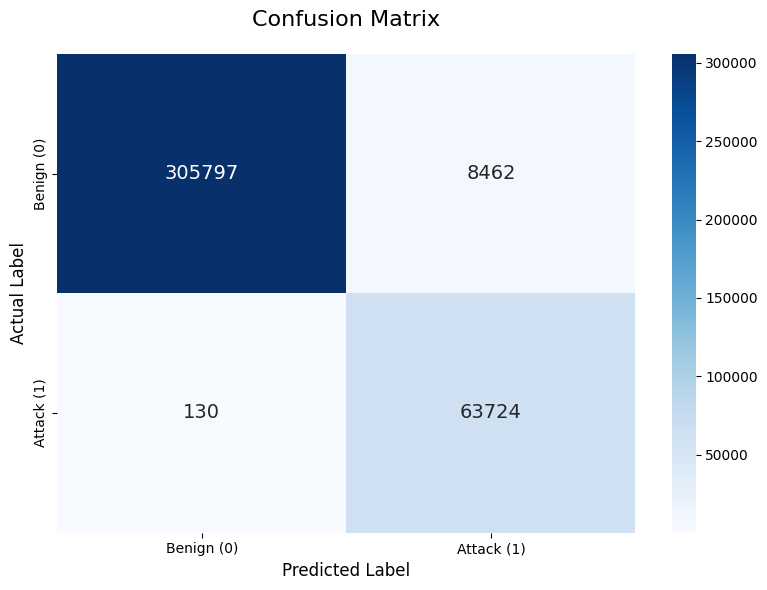

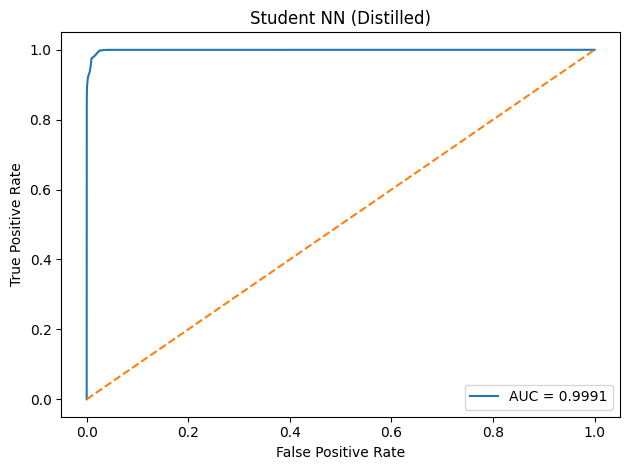

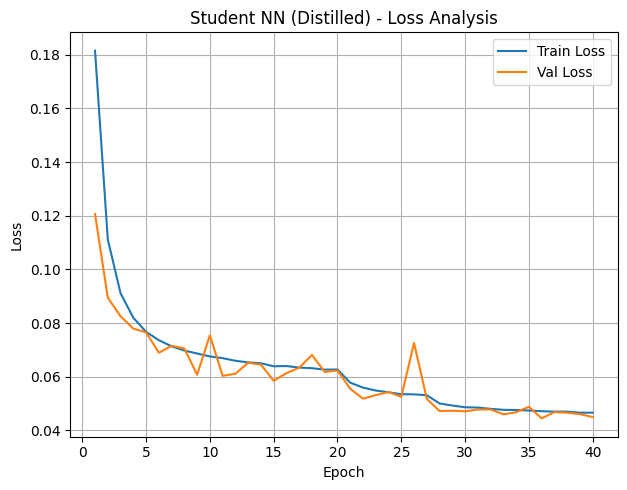

In [36]:
# Evaluasi biasa
plot_all_evaluation(
    y_true=y_test,
    y_prob=y_pred_prob,
    threshold=0.5428,
    model_name="Student NN (Distilled)"
)


In [ ]:
# ==========================================
# THRESHOLD OPTIMAL - YOUDEN'S J
# ==========================================

from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd

# 1. Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 2. Hitung Youden's J Statistic
youden_j = tpr - fpr

# 3. Ambil threshold terbaik
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print("🎯 Threshold Optimal (Youden’s J)")
print(f"Threshold        : {best_threshold:.4f}")
print(f"TPR (Recall)     : {tpr[best_idx]:.4f}")
print(f"TNR (Specificity): {1 - fpr[best_idx]:.4f}")
print(f"Youden's J       : {youden_j[best_idx]:.4f}")

# 4. Ringkas ke dalam tabel (opsional, bagus untuk paper)
threshold_table = pd.DataFrame({
    "Metric": [
        "Threshold Optimal",
        "True Positive Rate (TPR)",
        "True Negative Rate (TNR)",
        "Youden's J"
    ],
    "Value": [
        best_threshold,
        tpr[best_idx],
        1 - fpr[best_idx],
        youden_j[best_idx]
    ]
})

threshold_table


🎯 Threshold Optimal (Youden’s J)
Threshold        : 0.5428
TPR (Recall)     : 0.9977
TNR (Specificity): 0.9746
Youden's J       : 0.9724


,Metric,Value
0,Threshold Optimal,0.542760
1,True Positive Rate (TPR),0.997729
2,True Negative Rate (TNR),0.974626
3,Youden's J,0.972355


In [32]:
# ==========================================
# 7. CONVERT TO TFLITE (FLOAT32)
# ==========================================
print("\n🔄 Converting to TensorFlow Lite (Float32)...")

converter = tf.lite.TFLiteConverter.from_keras_model(student)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32] # Paksa Float32

tflite_model = converter.convert()

# Simpan File
if not os.path.exists('models'):
    os.makedirs('models')

tflite_path = 'models/tang.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ TFLite Model saved at: {tflite_path}")


🔄 Converting to TensorFlow Lite (Float32)...
INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpndgrfk06\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpndgrfk06\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmpndgrfk06'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 43), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2694949195600: TensorSpec(shape=(1, 43), dtype=tf.float32, name=None)
  2694949192720: TensorSpec(shape=(1, 43), dtype=tf.float32, name=None)
  2694952333392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694952336272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694952333776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694952327248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694952336080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694952334736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694952337232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694952335312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2694

In [33]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve

# Load TFLite
interpreter = tf.lite.Interpreter(model_path="models/tang.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prediksi probabilitas
y_prob = []
for i in range(len(X_test)):
    x = X_test[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], x)
    interpreter.invoke()
    y_prob.append(interpreter.get_tensor(output_details[0]['index'])[0][0])

y_prob = np.array(y_prob)


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print(f"🎯 Threshold Youden's J optimal: {best_threshold:.4f}")
print(f"TPR (Recall) : {tpr[best_idx]:.4f}")
print(f"FPR          : {fpr[best_idx]:.4f}")


🎯 Threshold Youden's J optimal: 0.5542
TPR (Recall) : 0.9976
FPR          : 0.0250


In [ ]:
# ==========================================
# 8. VERIFIKASI METADATA (UNTUK SNORT C++)
# ==========================================
print("\n🕵️ Extracting TFLite Metadata (CATAT INI)...")

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n--- [SNORT CONFIG] Input Tensor ---")
print(f"Index : {input_details[0]['index']}")
print(f"Shape : {input_details[0]['shape']}")
print(f"Type  : {input_details[0]['dtype']}")

print("\n--- [SNORT CONFIG] Output Tensor ---")
print(f"Index : {output_details[0]['index']}")
print(f"Shape : {output_details[0]['shape']}")
print(f"Type  : {output_details[0]['dtype']}")


🕵️ Extracting TFLite Metadata (CATAT INI)...

--- [SNORT CONFIG] Input Tensor ---
Index : 0
Shape : [ 1 43]
Type  : <class 'numpy.float32'>

--- [SNORT CONFIG] Output Tensor ---
Index : 17
Shape : [1 1]
Type  : <class 'numpy.float32'>


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
